In [18]:
## import libraries

import os
import random
import zlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.feature import canny
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.draw import line as draw_line

import json

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from typing import Tuple, Optional

from PIL import Image
import statsmodels.formula.api as smf

In [19]:
## define filepaths

project_path =  Path().resolve().parent
tables_path = os.path.join(project_path, "015_tables")
raw_data_path = os.path.join(project_path, "005_cleaned_data")
raw_data_path_targets = os.path.join(project_path, "007_targets")
viz_path = os.path.join(project_path, "020_visualizations")

print(project_path)

E:\Research2\VizEx_analysis_replication


In [20]:
# Automatically reload updated code from utils/*.py every time you run a cell
%load_ext autoreload
%autoreload 2

# Add the parent directory to the Python path (only needed if utils is not already importable)
import sys
from pathlib import Path
if str(project_path) not in sys.path:
    sys.path.append(str(project_path))

from utils.utils import *
from utils.detail_feature import *
from utils.viz import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# -------------------------------
# Load CSVs and register datasets
# (VizEx single-experiment version)
# -------------------------------

# Paths to CSV files
vizex_csv_path = os.path.join(tables_path, "vizex_features.csv")
vizex_targets_csv_path = os.path.join(tables_path, "vizex_targets_features.csv")

# Read CSVs
df_vizex = pd.read_csv(vizex_csv_path)
df_vizex_targets = pd.read_csv(vizex_targets_csv_path)

# Create working copies (this is where we’ll add focal points + feature columns)
df_vizex_features = df_vizex.copy(deep=True)
df_vizex_targets_features = df_vizex_targets.copy(deep=True)

# Quick checks
display(df_vizex.head())
display(df_vizex_targets.head())

# Image roots (edit these if your on-disk folder names differ)
raw_data_path_vizex = raw_data_path                 # participant images
raw_data_path_targets_vizex = raw_data_path_targets # target images

image_paths = {
    "vizex": raw_data_path_vizex,
    "vizex_targets": raw_data_path_targets_vizex,
}

# Dataset registry
# - dataset_id: selects dataframe + image path
# - domain_key: selects preprocessing conventions (now just 'vizex')
datasets = {
    "vizex": {
        "name": "VizEx",
        "domain_key": "vizex",
        "df_raw": df_vizex,
        "df": df_vizex_features,          # working df
        "image_path": image_paths["vizex"],
    },
    "vizex_targets": {
        "name": "VizEx Targets",
        "domain_key": "vizex",            # IMPORTANT: preprocess like vizex
        "df_raw": df_vizex_targets,
        "df": df_vizex_targets_features,
        "image_path": image_paths["vizex_targets"],
    },
}

# Sanity checks: required columns
REQUIRED_COLS = ["png_filename"]
for k, ds in datasets.items():
    missing = [c for c in REQUIRED_COLS if c not in ds["df"].columns]
    if missing:
        raise KeyError(f"Dataset '{k}' is missing required columns in df: {missing}")

# Sanity checks: image_path exists
for k, ds in datasets.items():
    if not os.path.isdir(ds["image_path"]):
        print(f"WARNING: image_path not found for '{k}': {ds['image_path']}")


,participant_code,condition_code,condition_name,condition_hz,condition_type,stimulus_type,trialn,png_filename,focal_x_norm,focal_y_norm,detail_raw,detail,r_directionality_raw,r_directionality,theta_directionality_raw,theta_directionality,brightness_raw,brightness,contrast_raw,contrast
0,TKB3728,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171012__sessionTime_202510170920_...,0.0,0.0,0.000837,0.038183,0.058464,0.080820,0.715280,0.916274,0.744486,0.744486,0.056889,0.056889
1,TKB3728,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171012__sessionTime_202510170920_...,0.0,0.0,0.000872,0.039785,0.058479,0.080841,0.714990,0.915903,0.746623,0.746623,0.057109,0.057109
2,ABU7735,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.003865,0.176419,0.825005,1.140489,0.029136,0.037324,0.997364,0.997364,0.011596,0.011596
3,ABU7735,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.003953,0.180417,0.825220,1.140786,0.028801,0.036895,0.997296,0.997296,0.011737,0.011737
4,BCE0029,7,80 Hz,80.0,CONTROL,LIGHT,2,saveTime_2510171013__sessionTime_202510170920_...,0.0,0.0,0.000246,0.011246,0.050434,0.069720,0.770978,0.987624,0.621041,0.621041,0.262712,0.262712


,condition_code,condition_name,png_filename,focal_x_norm,focal_y_norm,detail_raw,detail,r_directionality_raw,r_directionality,theta_directionality_raw,theta_directionality,brightness_raw,brightness,contrast_raw,contrast
0,A00,Image A00,A00.png,0.0,0.0,0.007142,0.325984,0.781645,1.080548,0.009310,0.011926,0.210665,0.210665,0.173777,0.173777
1,A01,Image A01,A01.png,0.0,0.0,0.010301,0.470164,0.286134,0.395552,0.205893,0.263750,0.415913,0.415913,0.175747,0.175747
2,A02,Image A02,A02.png,0.0,0.0,0.005755,0.262681,0.054612,0.075496,0.589442,0.755076,0.060296,0.060296,0.213347,0.213347
3,A03,Image A03,A03.png,0.0,0.0,0.010703,0.488512,0.257981,0.356633,0.271699,0.348046,0.148359,0.148359,0.082927,0.082927
4,A04,Image A04,A04.png,0.0,0.0,0.018649,0.851198,0.806852,1.115394,0.118869,0.152271,0.042522,0.042522,0.020700,0.020700


## Testing correlation between target images and recreation images features

In [22]:
def model_summary_string(mdf, var, precision=3):
    b = mdf.params[var]
    se = mdf.bse[var]
    p = mdf.pvalues[var]
    if p < 0.0001:
        p_str = "p < .0001"
    elif p < 0.001:
        # Avoid "p = .000"
        p_str = "p < .001"
    else:
        p_str = f"p = {p:.3f}".replace("0.", ".")
    return f"b = {b:.{precision}f}, SE = {se:.{precision}f}, {p_str}"

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

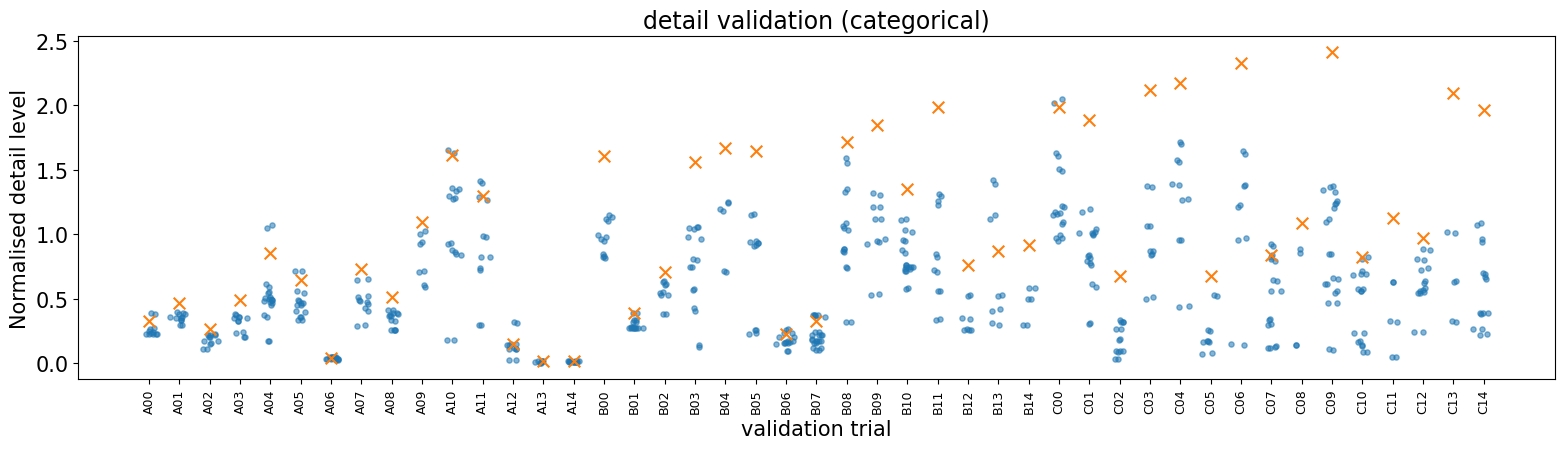

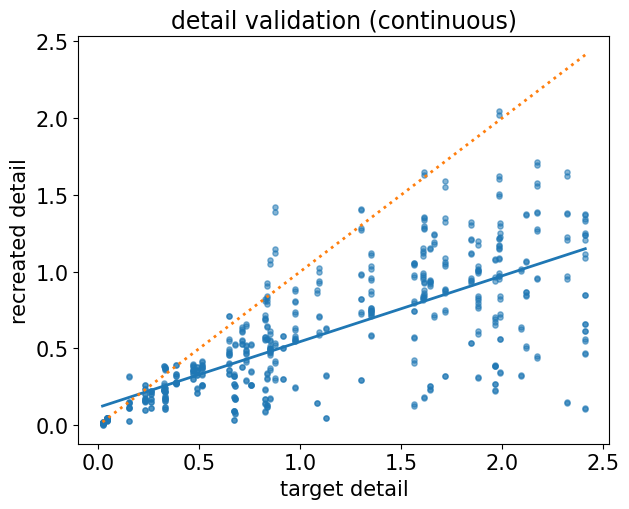

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

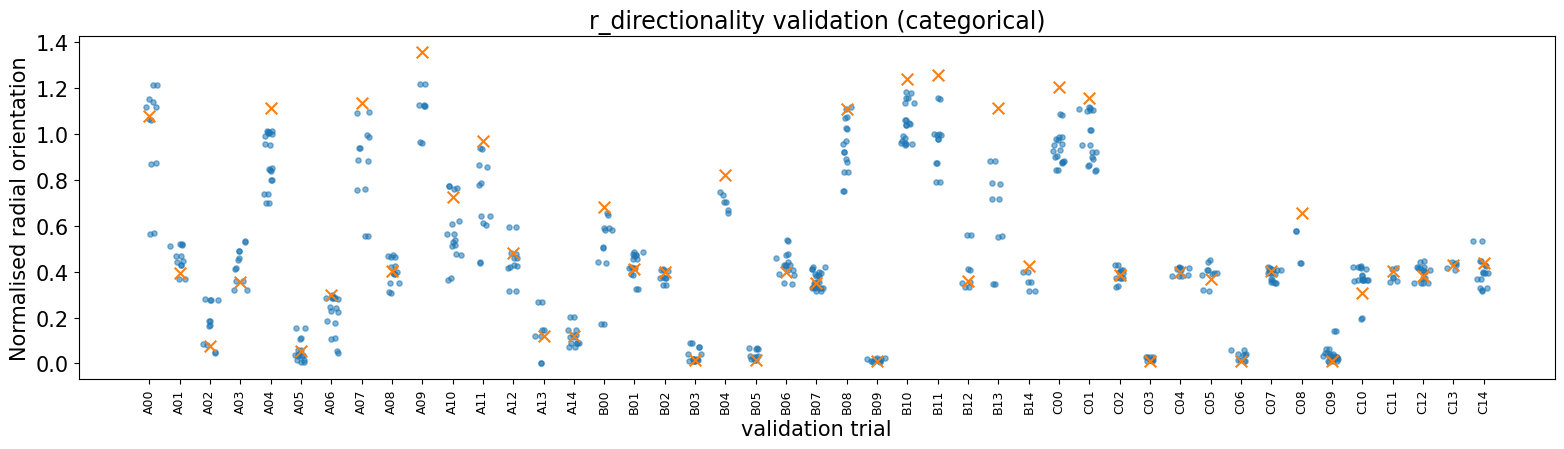

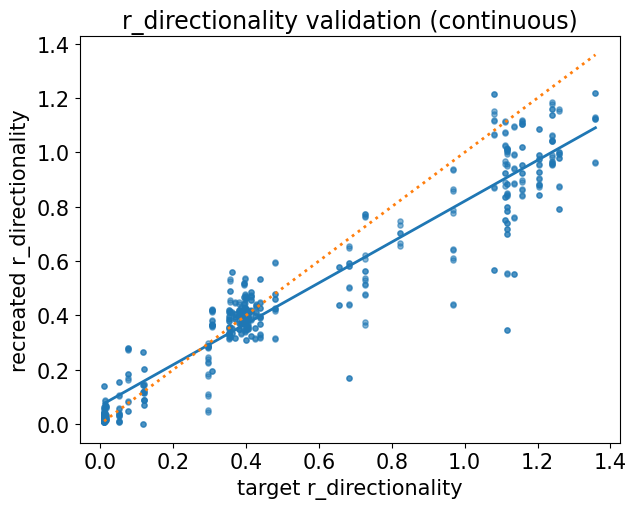

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

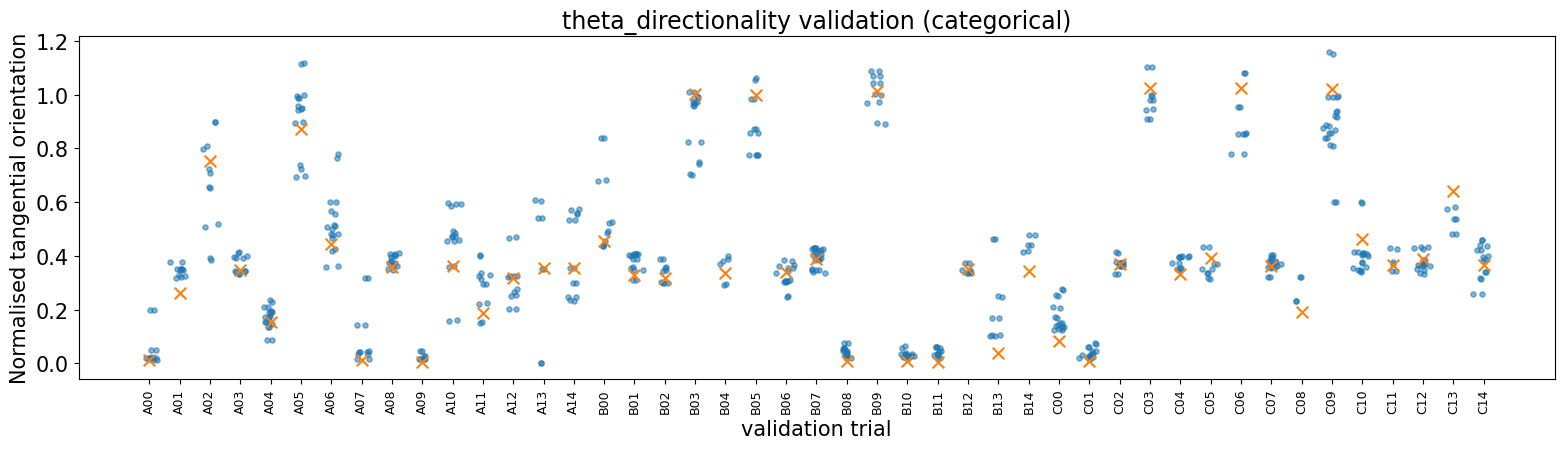

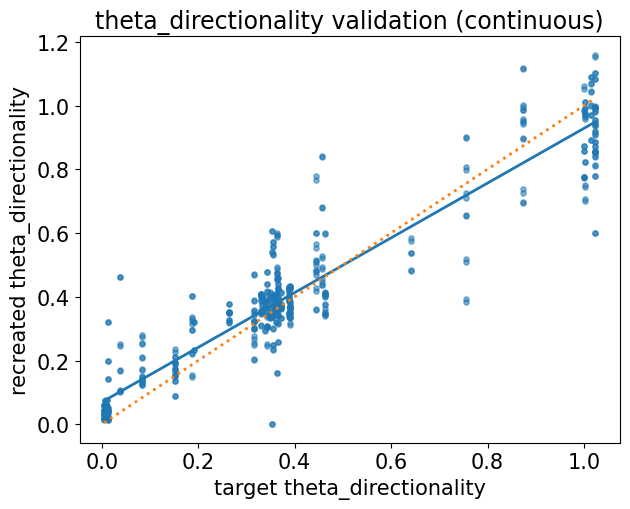

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

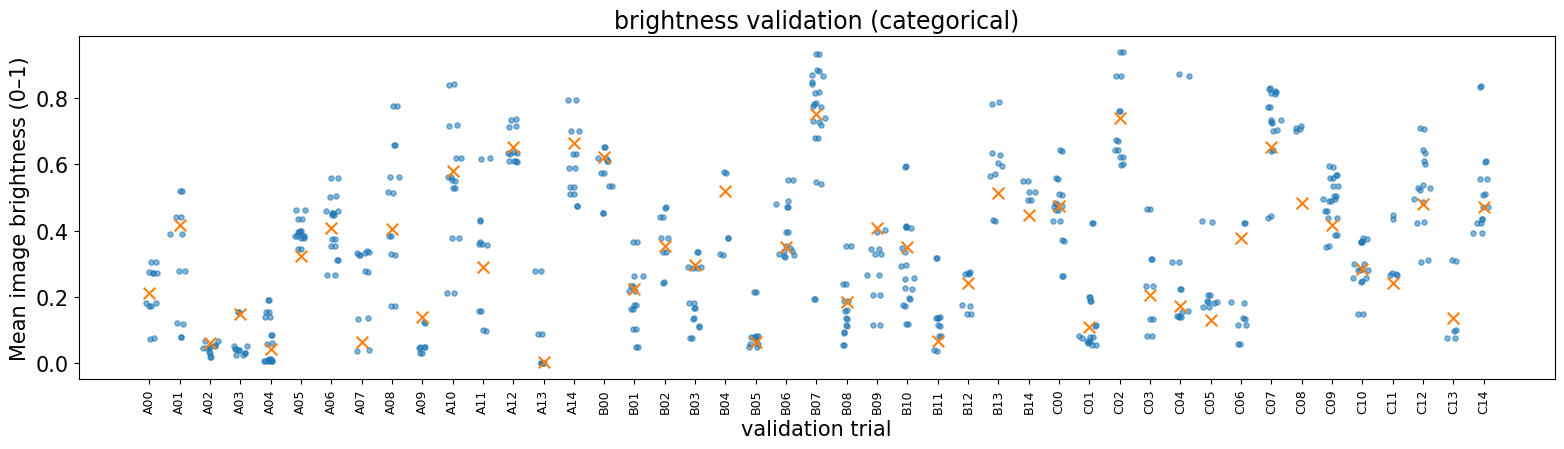

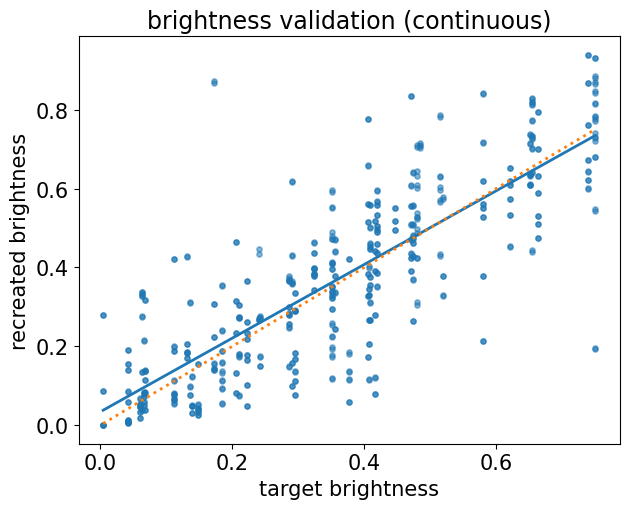

e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
e:\Research2\VizEx_analysis_replication\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e

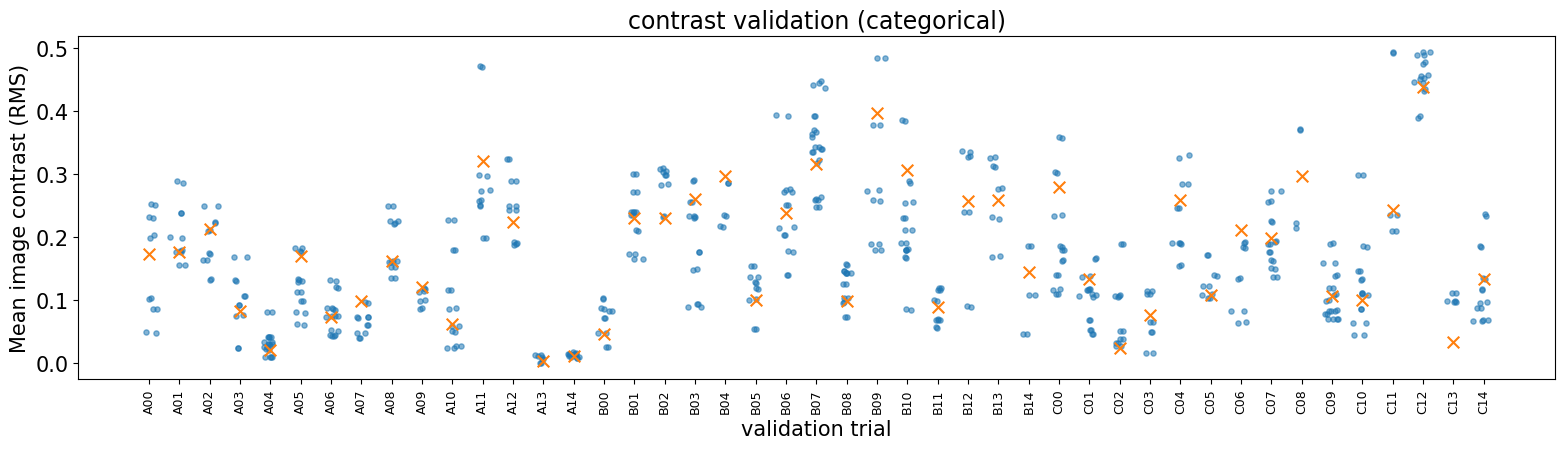

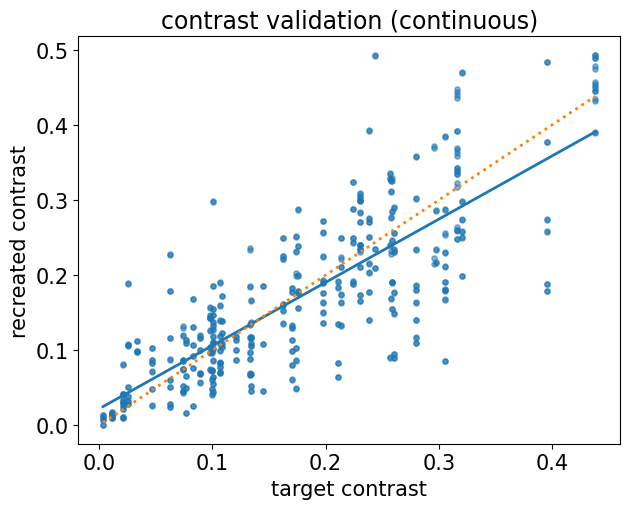

,feature,b,se,z,p,n
0,detail,0.420363,0.013610,30.887137,1.778030e-209,592
1,r_directionality,0.758359,0.010192,74.407659,0.000000e+00,592
2,theta_directionality,0.849965,0.012140,70.013894,0.000000e+00,592
3,brightness,0.930747,0.024696,37.687886,0.000000e+00,592
4,contrast,0.824456,0.023855,34.560759,9.824722e-262,592


In [23]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ============================================================
# VizEx validation (single experiment; many validation trials)
# - expects datasets["vizex"]["df"] and datasets["vizex_targets"]["df"]
# - both already contain the saved feature columns
# ============================================================

text_size = 15
title_size = int(text_size * 1.15)

# ---------- helpers ----------

def _is_validation_code(x: str) -> bool:
    return bool(re.fullmatch(r"[ABC]\d{2}", str(x).strip()))

def _nat_key(code: str):
    # A00..A14, B00.., C00.. ordering
    s = str(code).strip()
    m = re.fullmatch(r"([A-Z])(\d+)", s)
    if not m:
        return (999, 999, s)
    letter, num = m.group(1), int(m.group(2))
    return (ord(letter), num, s)

def prepare_data_vizex(feature: str, datasets: dict) -> pd.DataFrame:
    """
    Returns long df with columns:
      condition_code, participant_code, <feature>_rec, <feature>_targ
    """
    df_rec = datasets["vizex"]["df"].copy()
    df_targ = datasets["vizex_targets"]["df"].copy()

    # filter to validation trials (robust to missing stimulus_type/condition_type columns)
    if "stimulus_type" in df_rec.columns:
        df_rec = df_rec[df_rec["stimulus_type"].astype(str).str.upper().eq("IMAGE")].copy()
    elif "condition_type" in df_rec.columns:
        df_rec = df_rec[df_rec["condition_type"].astype(str).str.upper().eq("VALIDATION")].copy()
    else:
        df_rec = df_rec[df_rec["condition_code"].map(_is_validation_code)].copy()

    df_rec = df_rec[df_rec["condition_code"].map(_is_validation_code)].copy()
    df_targ = df_targ[df_targ["condition_code"].map(_is_validation_code)].copy()

    rec_col = feature
    targ_col = feature

    df_rec_sub = df_rec[["condition_code", "participant_code", rec_col]].rename(
        columns={rec_col: f"{feature}_rec"}
    )
    df_targ_sub = df_targ[["condition_code", targ_col]].rename(
        columns={targ_col: f"{feature}_targ"}
    )

    df = pd.merge(df_rec_sub, df_targ_sub, on="condition_code", how="left")
    df = df.dropna(subset=[f"{feature}_targ", f"{feature}_rec"]).copy()

    # stable ordering
    df["condition_code"] = df["condition_code"].astype(str).str.strip()
    df["cond_order"] = df["condition_code"].map(_nat_key)
    df = df.sort_values(["cond_order", "participant_code"]).drop(columns=["cond_order"]).reset_index(drop=True)
    return df

def run_mixedlm(feature: str, df: pd.DataFrame):
    """
    MixedLM: recreation ~ target, random intercept for participant.
    Returns (mdf, b, se, z, p).
    """
    rec_col = f"{feature}_rec"
    targ_col = f"{feature}_targ"

    md = smf.mixedlm(f"{rec_col} ~ {targ_col}", df, groups=df["participant_code"])

    methods = ["lbfgs", "bfgs", "cg", "powell", "nm"]
    last = None
    for meth in methods:
        try:
            mdf = md.fit(reml=False, method=meth, maxiter=2000, disp=False)
            last = mdf
            if getattr(mdf, "converged", False):
                break
        except Exception:
            continue
    if last is None:
        raise RuntimeError("MixedLM fit failed for all optimizers.")

    mdf = last
    b  = float(mdf.params.get(targ_col, np.nan))
    se = float(mdf.bse.get(targ_col, np.nan))
    z  = float(mdf.tvalues.get(targ_col, np.nan))
    p  = float(mdf.pvalues.get(targ_col, np.nan))
    return mdf, b, se, z, p

# ---------- plotting ----------

def plot_feature_categorical(feature: str, df: pd.DataFrame, *, y_label: str, jitter: float = 0.12, seed: int = 0):
    """
    Sanity plot:
      x-axis: validation trial code (categorical)
      target: 'X' at each category
      recreations: dots with slight x-jitter
    """
    rng = np.random.RandomState(seed)
    rec_col = f"{feature}_rec"
    targ_col = f"{feature}_targ"

    codes = sorted(df["condition_code"].unique().tolist(), key=_nat_key)
    code_to_x = {c: i for i, c in enumerate(codes)}
    xs = df["condition_code"].map(code_to_x).to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=(max(10, len(codes) * 0.35), 4.6))

    # recreations
    ax.scatter(xs + rng.normal(0, jitter, size=len(xs)), df[rec_col].to_numpy(float), s=14, alpha=0.55)

    # targets (one per code)
    targ_by_code = df.groupby("condition_code", sort=False)[targ_col].first()
    xt = np.array([code_to_x[c] for c in targ_by_code.index], dtype=float)
    yt = targ_by_code.to_numpy(dtype=float)
    ax.scatter(xt, yt, s=70, marker="x")

    ax.set_title(f"{feature} validation (categorical)", fontsize=title_size)
    ax.set_ylabel(y_label, fontsize=text_size)
    ax.set_xlabel("validation trial", fontsize=text_size)
    ax.set_xticks(range(len(codes)))
    ax.set_xticklabels(codes, rotation=90, fontsize=9)
    ax.tick_params(axis="y", labelsize=text_size)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

def plot_feature_continuous(feature: str, df: pd.DataFrame, *, y_label: str):
    """
    Continuous plot:
      x-axis: target feature value
      y-axis: recreated feature value
      overlays:
        - OLS best-fit line
        - y = x dotted line
    """
    rec_col = f"{feature}_rec"
    targ_col = f"{feature}_targ"

    x = df[targ_col].to_numpy(dtype=float)
    y = df[rec_col].to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=(6.4, 5.2))
    ax.scatter(x, y, s=14, alpha=0.55)

    # OLS best-fit line for display
    m = smf.ols(f"{rec_col} ~ {targ_col}", data=df).fit()
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    xx = np.linspace(xmin, xmax, 200)
    yy = m.params["Intercept"] + m.params[targ_col] * xx
    ax.plot(xx, yy, linewidth=2)

    # y=x reference (ideal)
    ax.plot([xmin, xmax], [xmin, xmax], linestyle=":", linewidth=2)

    ax.set_title(f"{feature} validation (continuous)", fontsize=title_size)
    ax.set_xlabel(f"target {feature}", fontsize=text_size)
    ax.set_ylabel(f"recreated {feature}", fontsize=text_size)
    ax.tick_params(axis="both", labelsize=text_size)
    plt.tight_layout()
    plt.show()

# ---------- master runner ----------

def run_vizex_validation(datasets: dict):
    features = [
        ("detail",               "Normalised detail level"),
        ("r_directionality",     "Normalised radial orientation"),
        ("theta_directionality", "Normalised tangential orientation"),
        ("brightness",           "Mean image brightness (0–1)"),
        ("contrast",             "Mean image contrast (RMS)"),
    ]

    results = []
    merged = {}

    for feature, y_label in features:
        df = prepare_data_vizex(feature, datasets)
        merged[feature] = df

        mdf, b, se, z, p = run_mixedlm(feature, df)
        results.append({"feature": feature, "b": b, "se": se, "z": z, "p": p, "n": len(df)})

        # plots: categorical + continuous
        plot_feature_categorical(feature, df, y_label=y_label)
        plot_feature_continuous(feature, df, y_label=y_label)

    results_df = pd.DataFrame(results)
    display(results_df)
    return results_df, merged

# ---------------- RUN ----------------
vizex_validation_results, vizex_validation_dfs = run_vizex_validation(datasets)
